In [1]:
import io
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
from ultralytics import YOLO
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
from IPython.display import clear_output
import socket
import time
from datetime import datetime
import shutil
from random import randint
import random
import re
import colorsys
import math
from scipy.spatial import Voronoi
import matplotlib.colors as mcolors
from ultralytics.data.augment import LetterBox
from ultralytics.utils.plotting import Annotator, colors, save_one_box
import torch
from copy import deepcopy 

# reload_path = r"S:\Phys\FIV906 NeuroArbors\02d\YO 384 0322 MAXI\map75=0719551 YOLOv8n-seg ml idx=13 ep=19 btch=16 rnd=4174380\weights\best.pt"
# reload_path = r"S:\Phys\FIV906 NeuroArbors\02f\YO 384 0424 MAXI\map75=0793351 YOLOv8n-seg .yaml idx=14 ep=20 btch=16 rnd=5572530\weights\best.pt"
reload_path = r"S:\Phys\FIV906 NeuroArbors\02f\YO 384 0501 MAXI\map75=0943549 YOLOv8l-seg .yaml idx=1 ep=32 btch=64 rnd=3927527\weights\best.pt"
model = YOLO(reload_path)
# to_viz = r"S:\Phys\FIV906 NeuroArbors\toViz"
to_viz = r"C:\Users\FIVE\Desktop\fake_neuron_pictures"
res = model.predict(to_viz, show=False, retina_masks=True)

c:\Users\FIVE\anaconda3\envs\torch01\lib\site-packages\torch\nn\modules\module.py:1150: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:30.)
  return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)



image 1/6 C:\Users\FIVE\Desktop\fake_neuron_pictures\006127.bmp: 384x384 3 Neurites, 10.0ms
image 2/6 C:\Users\FIVE\Desktop\fake_neuron_pictures\006132.bmp: 384x384 5 Neurites, 9.6ms
image 3/6 C:\Users\FIVE\Desktop\fake_neuron_pictures\006134.bmp: 384x384 6 Neurites, 10.0ms
image 4/6 C:\Users\FIVE\Desktop\fake_neuron_pictures\006135.bmp: 384x384 7 Neurites, 10.0ms
image 5/6 C:\Users\FIVE\Desktop\fake_neuron_pictures\006138.bmp: 384x384 6 Neurites, 11.0ms
image 6/6 C:\Users\FIVE\Desktop\fake_neuron_pictures\006140.bmp: 384x384 7 Neurites, 10.0ms
Speed: 1.8ms preprocess, 10.1ms inference, 229.9ms postprocess per image at shape (1, 3, 384, 384)


In [2]:
# Functions

def sanitize_for_filesystem(input_string, len = 6):
    safe_string = re.sub(r'[^a-zA-Z0-9]', '', input_string)
    return safe_string[:len]

def save_tile_results(res2, save_path, max_tile_cols = 6, divider_width = 4, show=False):
    divider_color = (255, 0, 0)  # Divider color in RGB (red in this example)

    def calculate_canvas_size(images, max_cols, img_width, img_height, divider_width):
        #rows = (len(images) + max_cols - 1) // max_cols
        canvas_width = (img_width + divider_width) * min(len(images), max_cols) - divider_width
        canvas_height = (img_height * 2 + divider_width) #* rows - divider_width
        return canvas_width, canvas_height

    image_pairs = []

    for result in res2:
        img_orig = result.orig_img
        img_labeled = result.plot(labels=False, conf=False)
        img_orig_pil = Image.fromarray(img_orig)
        img_labeled_pil = Image.fromarray(img_labeled)
        image_pairs.append((img_orig_pil, img_labeled_pil))

    if not image_pairs:
        print("No images to display.")
    else:
        img_width, img_height = image_pairs[0][0].size
        canvas_width, canvas_height = calculate_canvas_size(image_pairs, max_tile_cols, img_width, img_height, divider_width)
        canvas = Image.new('RGB', (canvas_width, canvas_height), "white")
        draw = ImageDraw.Draw(canvas)

        for i, (img_orig, img_labeled) in enumerate(image_pairs[:max_tile_cols]):
            col = i % max_tile_cols; row = i // max_tile_cols
            top_left_x = col * (img_width + divider_width); top_left_y = row * (img_height * 2 + divider_width)
            canvas.paste(img_orig, (top_left_x, top_left_y))
            canvas.paste(img_labeled, (top_left_x, top_left_y + img_height + divider_width))

            # if col > 0:
            #     draw.line([(1+ top_left_x - divider_width, top_left_y), (1+top_left_x - divider_width, top_left_y + img_height * 2)], fill=divider_color, width=divider_width)
            #     draw.line([(0, top_left_y - divider_width), (canvas_width, top_left_y - divider_width)], fill=divider_color, width=divider_width)
        if (show): display(canvas)
        if (save_path!=""): canvas.save(save_path)

def results_toDF(res2, addIDCol = False):
    data = []
    for result in res2:
        boxes = result.boxes
        inst = 0
        for box in boxes:
            x, y, w, h = box.xywh[0].tolist()
            inst += 1
            data.append({
                'Fullpath': result.path,
                'Filename' : os.path.basename(result.path),
                'Instance' : inst,
                'Class': box.cls[0].item(),
                'Conf': box.conf[0].item(),
                'x': x, 'y': y,
                'w': w, 'h': h,
                'xc' : x + w/2,
                'yc' : y + h/2,
                'Circ Area' : (0.858 * w * h)
            })
    df = pd.DataFrame(data)
    if (addIDCol): 
        df['ID'] = df.groupby('path').cumcount()
    return df

def results_toCSV(res2, save_path):
    df = results_toDF(res2)
    df.to_csv(save_path, index=False)

def polygon_area(coords):
    x = coords[:, 0]; y = coords[:, 1]
    i = np.arange(len(x))
    # 'shoelace' formula
    # return 0.5*np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
    return np.abs(np.sum(x[i-1]*y[i]-x[i]*y[i-1])*0.5)

def find_parents(classes, image):
    class0_indices = np.where(classes == 0)[0]
    class1_indices = np.where(classes == 1)[0]
    
    class1_centers = image.boxes.xywh[class1_indices]
    class0_centers = image.boxes.xywh[class0_indices]
    
    class1_parents = []
    for class1_coord in class1_centers.numpy():
                # print("the class1 instance: ", class1_coord)
                
                droplet_x = class1_coord[0]
                droplet_y = class1_coord[1]
                # print("droplet x, y coords: ", droplet_x, droplet_y)
                min_distance_from_cells = math.inf
                parent_cell_index = 0
                for i, class0_coord in enumerate(class0_centers.numpy()):
                    # print("the class0 instance: ", class0_coord)
                    
                    cell_x = class0_coord[0]
                    cell_y = class0_coord[1]
                    # print("cell x, y coords: ", cell_x, cell_y)
                    point1 = np.array((droplet_x, droplet_y))
                    point2 = np.array((cell_x, cell_y))
                    dist = np.linalg.norm(point1 - point2)
                    # print("dist from class0 instance: ", dist)
                    if dist < min_distance_from_cells:
                        min_distance_from_cells = dist
                        parent_cell_index = i
                        
                # print("parent cell index: ", parent_cell_index)        
                class1_parents.append(class0_indices[parent_cell_index])
    return class1_parents

def find_first_file(m_folder, m_contains):
    for root, dirs, files in os.walk(m_folder):
        for file in files:
            if m_contains in file:
                return os.path.join(root, file)
    return None

def create_multichannel_array(folder_path):
    image_arrays = []
    image_names = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg','.bmp','.tif')):
                file_path = os.path.join(root, file)
                t_img = Image.open(file_path).convert('L')  # Convert to grayscale if not already
                t_arr = np.array(t_img)
                if t_arr.ndim == 2:  # Ensure the image is grayscale
                    image_arrays.append(t_arr)
                    image_names.append(file)
    
    if not image_arrays:
        return None  # Or raise an exception if you prefer

    # Stack the arrays along a new axis to create a multi-channel array
    multi_channel_array = np.stack(image_arrays, axis=-1)
    return multi_channel_array, image_names

def get_color_by_id(point_region_id, total_ids):
    hue = point_region_id / total_ids # Scale the hue by the number of unique IDs, wrapping around the hue circle
    saturation = 0.9; value = 0.9  # Keep saturation and value high for bright colors
    rgb = colorsys.hsv_to_rgb(hue, saturation, value)
    return tuple(int(c * 255) for c in rgb) # Convert to 0-255 scale for RGB colors in PIL

def get_vor_boundaries(boxes, ImgIfDesired = None):
    points= []; vor_verts = {}
    for idx in range(len(boxes)): points.append((boxes[idx][0], boxes[idx][1]))
    vor = Voronoi(points)
    for point_region_id, region_id in enumerate(vor.point_region): #this is needed to preserve the order
        if (-1 not in vor.regions[region_id]):
            region_vertices = vor.vertices[vor.regions[region_id]]
            vor_verts[point_region_id] = region_vertices.tolist()

    vor_verts_list = []; default_triangle_height = 2; default_triangle_base_length = 4
    for idx, point in enumerate(points):
        if idx in vor_verts:  # Voronoi region exists
            vor_verts_list.append(vor_verts[idx])
        else:  # Create default triangle for missing regions
            bl_vertex = (point[0] - default_triangle_base_length / 2, point[1])
            br_vertex = (point[0] + default_triangle_base_length / 2, point[1])
            top_vertex = (point[0], point[1] + default_triangle_height)  
            vor_verts_list.append([bl_vertex, br_vertex, top_vertex])
    
    if (ImgIfDesired):
        drawV = ImageDraw.Draw(ImgIfDesired)
        r = 2  # radius of the points
        for point_region_id, point in enumerate(points):
            outline_color = get_color_by_id(point_region_id, len(points))
            left_up_point = (point[0] - r, point[1] - r)
            right_down_point = (point[0] + r, point[1] + r)
            if vor_verts.get(point_region_id) and len(vor_verts[point_region_id]) > 0:
                polygon_vertices_tuples = [tuple(vertex) for vertex in vor_verts[point_region_id]]
                drawV.polygon(polygon_vertices_tuples, width=3, outline=outline_color)
            drawV.ellipse([left_up_point, right_down_point], fill=outline_color)

        display(imgV)
    return vor_verts_list

def find_mask_intensities(img_data, image_array, file_name, shift_x = 0, shift_y = 0, include_headers = True, meta_name = "NA", tile_name = "NA"):
    sto = io.StringIO()
    sth = ''; d = '\t'

    def bstr_h(sth1):
        nonlocal sth
        sth += sth1

    def bstr_m(st1):
        sto.write(st1)

    def bstr_m_start():
        nonlocal sth, sto
        st = sth + '\r' + sto.getvalue()
        sto.close()
        sto = io.StringIO()
        sto.write(st)

    def get_mask(vertices):
        polygon_path = mpltPath.Path(vertices) # Create a path object from the vertices
        inside_polygon = polygon_path.contains_points(class_points)
        mask = inside_polygon.reshape(xx.shape) # Reshape the mask back to the image shape
        return mask

    width =image_array.shape[1]; height = image_array.shape[0]; channels = image_array.shape[2]
    boxes = img_data.boxes.cpu()
    img_box_centers = boxes.xywh 
    img_mask_coords = None if img_data.masks is None else img_data.masks.xy
    img_vor_coords = get_vor_boundaries(img_box_centers)

    first = include_headers; masks = {}
    print("width =",width,"height =",height,"chs =",channels,"boxes =",len(img_box_centers),"vor =",len(img_vor_coords))
    xx, yy = np.meshgrid(np.arange(width),np.arange(height)) # Create a mesh grid of coordinate values
    x_flat = xx.flatten(); y_flat = yy.flatten()
    class_points = np.vstack((x_flat, y_flat)).T # Create a list of (x, y) points from the flattened grid
    for idx in range(len(img_box_centers)):
        if (idx % 250 == 0): print("Measuring Intensities",idx)
        bbox_xywh = img_box_centers[idx]
        bbox_corners = [[bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]],[bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]] ,[bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]], [bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]]]
        vor_corners = img_vor_coords[idx]
        polys = { "box": bbox_corners, "poly": img_mask_coords, "vor": vor_corners }
        masks = {key: get_mask(value) for key, value in polys.items() if value}

        if (first): bstr_h('FileName' + d + 'MetaName' + d + 'TileName' + d + 'ObjectID' + d + 'Class'                      + d + 'Confidence'                  + d + 'cx' + d + 'cy' + d)
        bstr_m(             file_name + d + meta_name  + d +  tile_name + d + str(idx)   + d + str(boxes[idx].cls.item()) + d + str(boxes[idx].conf.item()) + d + str(bbox_xywh[0].item() + shift_x) + d + str(bbox_xywh[1].item() + shift_y))

        # Look at each mask for each channel
        for c in range(channels):
            cs = str(c)
            for key in masks:
                selected_pixels = image_array[:, :, c][masks[key]]
                area = len(selected_pixels)
                if (first and c==0): bstr_h(key + ' AreaP' + d)
                if (c==0): bstr_m(               str(area) + d)

                sum = np.sum(selected_pixels)
                avg = np.average(selected_pixels)
                std = np.std(selected_pixels)
                if (first): bstr_h(key + ' Total Intensity wv' + cs + d + key + ' Avg Intensity wv' + cs + d + key + ' Std Intensity wv' + cs + d)
                bstr_m(                    str(sum)                 + d + str(avg)                       + d + str(std)                       + d)

        if (first): bstr_m_start(); first = False
        bstr_m('\r')
    return sto.getvalue()

def Predict_OnPartsOfImage(model, original_image_name, full_image_arr_predict, full_image_arr_measure = None, save_path = None, new_w = 256, new_h = 256, overlap_amount = 0, fill_edges = False, include_headers = True, meta_name = "NA", maxdets = 6666, minconf = 0.25):
    def get_piece(t_arr, x, y):
        piece = t_arr[y:min(y + new_h, t_arr.shape[0]), x:min(x + new_w, t_arr.shape[1])] # Calculate the dimensions of the piece
        if fill_edges: # Create a new array filled with zeros (black) of the desired final size
            filled_piece = np.zeros((new_h, new_w), dtype=t_arr.dtype)
            filled_piece[:piece.shape[0], :piece.shape[1]] = piece
            piece = filled_piece
        return piece
            
    t_arr = full_image_arr_predict
    first = include_headers
    st = io.StringIO()
    for y in range(0, t_arr.shape[0], new_h - overlap_amount):
        for x in range(0, t_arr.shape[1], new_w - overlap_amount):
            piece_pred = get_piece(t_arr, x, y)
            piece_meas = get_piece(full_image_arr_measure, x, y) if (full_image_arr_measure is not None) else piece_pred
            tilename = str(x) + "," + str(y); print("Region:",tilename)
            predictions = model.predict(piece_pred, show=False, max_det=maxdets) #minconf
            #img_array=predictions[0].plot(labels=False, boxes=True, masks=True); display(Image.fromarray(img_array[..., ::-1]))
            st.write(find_mask_intensities(predictions[0], piece_meas, original_image_name, x, y, first, meta_name, tilename))
            first = False

    strRet = st.getvalue()
    if (save_path is not None):
        with open(save_path, 'a') as file: file.write(strRet)
        st.close()
    print("Done with File")
    return strRet

def work_on_folder(model, SubFolder, PredContains, IncludeHeaders = True, save_path = None, maxdet = 6000):
    file_pred = find_first_file(SubFolder, PredContains)
    pred_arr = np.array(Image.open(file_pred).convert('RGB'))  # Convert to RGB
    meas_arr, names = create_multichannel_array(SubFolder)
    st = Predict_OnPartsOfImage(model, file_pred, pred_arr, meas_arr, None, 553, 553, 0, False, IncludeHeaders, SubFolder, maxdet)
    if (save_path is not None): 
        with open(save_path, 'a') as file: file.write(st)
    print("Done with Files")
    return st, names

def yolo_plot_dif_colors(result, img = None, line_width=None, font_size=None, font="Arial.ttf", pil=False, boxes = False, labels = False, probs = True, im_gpu = None):
    if img is None and isinstance(result.orig_img, torch.Tensor):
        img = (result.orig_img[0].detach().permute(1, 2, 0).contiguous() * 255).to(torch.uint8).cpu().numpy()

    names = result.names
    is_obb = result.obb is not None
    pred_boxes, show_boxes = result.obb if is_obb else result.boxes, boxes
    pred_masks, show_masks = result.masks, True
    pred_probs, show_probs = result.probs, probs

    annotator = Annotator(
        deepcopy(result.orig_img if img is None else img),
        line_width,
        font_size,
        font,
        pil or (pred_probs is not None and show_probs),  # Classify tasks default to pil=True
        example=names,
    )

    if pred_masks and show_masks:
        if im_gpu is None:
            img = LetterBox(pred_masks.shape[1:])(image=annotator.result())
            im_gpu = (
                torch.as_tensor(img, dtype=torch.float16, device=pred_masks.data.device)
                .permute(2, 0, 1)
                .flip(0)
                .contiguous()
                / 255
            )
    idx = pred_boxes.cls if pred_boxes else range(len(pred_masks))
    # print([colors(x, True) for x in idx])
    # annotator.masks(pred_masks.data, colors=[colors(x, True) for x in idx], im_gpu=im_gpu)
    annotator.masks(pred_masks.data, colors=[colors(x, True) for x in random.sample(range(len(colors.palette)), len(pred_masks.data))], im_gpu=im_gpu)

    # print(type(annotator.result()))
    return Image.fromarray(annotator.result())

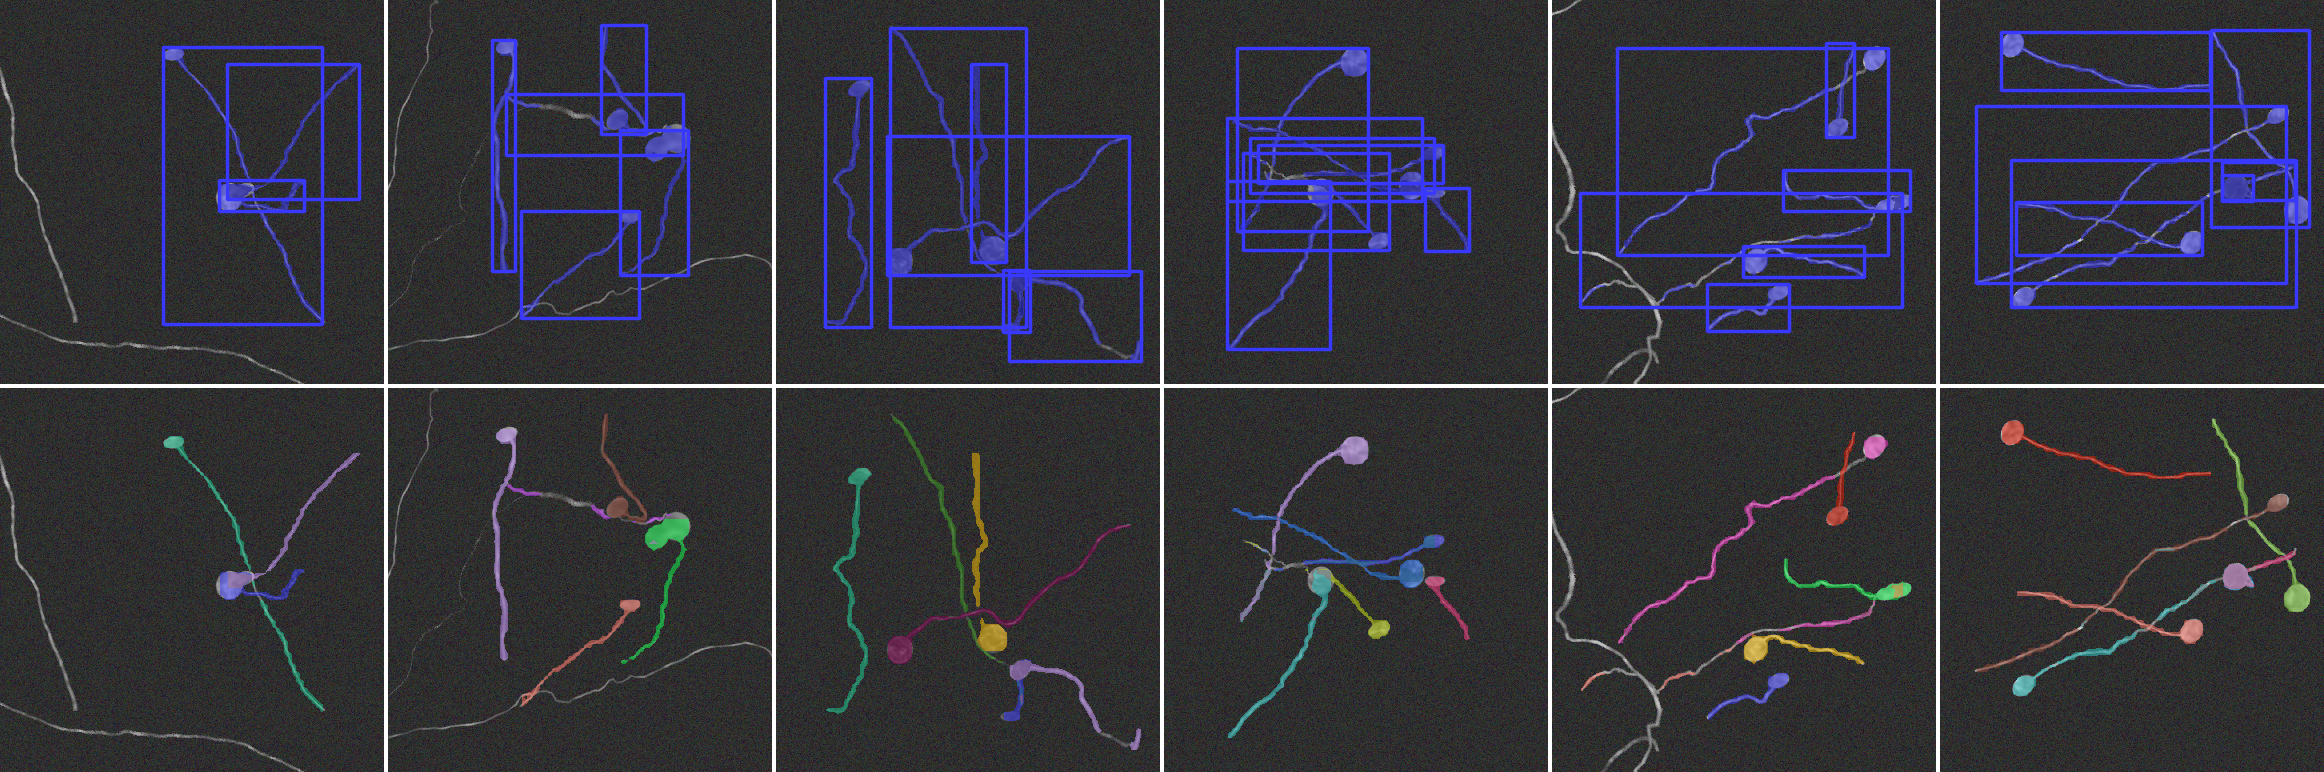

In [3]:
res2 = res; save_path = ""; max_tile_cols = 6; divider_width = 4; show=True
divider_color = (255, 0, 0)  # Red divider color

def calculate_canvas_size(images, max_cols, img_width, img_height, divider_width):
    canvas_width = (img_width + divider_width) * min(len(images), max_cols) - divider_width
    canvas_height = (img_height * 2 + divider_width) 
    return canvas_width, canvas_height

def draw_polygons(draw, polygons):
    for i, polygon in enumerate(polygons):
        color = get_color_by_id(i, len(polygons))
        draw.polygon(polygon, fill=color, outline='white')

image_pairs = []

for result in res2:
    # img_orig = result.orig_img
    # img_labeled = result.plot(labels=False, boxes=False, masks=True)
    img_orig = result.plot(labels=False, boxes=True, masks=True)
    img_orig_pil = Image.fromarray(img_orig)
    # img_labeled_pil = Image.fromarray(img_labeled)
    img_labeled_pil = yolo_plot_dif_colors(result)

    polygons = result.masks.xy
    # print(result.path, len(result), len(result.masks), len(result.masks.xy))
    # draw_orig = ImageDraw.Draw(img_orig_pil); draw_polygons(draw_orig, polygons)          # Draw polygons on original imag
    # draw_labeled = ImageDraw.Draw(img_orig_pil); draw_polygons(draw_labeled, polygons)  # Draw polygons on labeled image
    
    image_pairs.append((img_orig_pil, img_labeled_pil))

if not image_pairs:
    print("No images to display.")
else:
    img_width, img_height = image_pairs[0][0].size
    canvas_width, canvas_height = calculate_canvas_size(image_pairs, max_tile_cols, img_width, img_height, divider_width)
    canvas = Image.new('RGB', (canvas_width, canvas_height), "white")
    draw = ImageDraw.Draw(canvas)

    for i, (img_orig, img_labeled) in enumerate(image_pairs[:max_tile_cols]):
        col = i % max_tile_cols; row = i // max_tile_cols
        top_left_x = col * (img_width + divider_width); top_left_y = row * (img_height * 2 + divider_width)
        canvas.paste(img_orig, (top_left_x, top_left_y))
        canvas.paste(img_labeled, (top_left_x, top_left_y + img_height + divider_width))

    if show:
        display(canvas)
    if save_path:
        canvas.save(save_path)